In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import networkx as nx
from tqdm import tqdm
from PIL import Image
import json
import copy
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time

In [2]:
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import sum_it, data_iterations
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.network import load_model, train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.crp_attribution import CRPAttribution
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures

%reload_ext autoreload
%autoreload 2

In [3]:
MODEL_ZOO_INFOS_PATH = "outputs/final_models.json"#"outputs/seeded_model_accuracies.json"
MODEL_NAME = "../clustermodels/final"
with open(MODEL_ZOO_INFOS_PATH, "r") as f:
    modelzoo = json.load(f)


MAX_INDEX = 491520
STEP_SIZE = 40200 # 1033, 2011, 2777, 5381, 7069, 13267, 18181
indices = range(0, MAX_INDEX, STEP_SIZE)
LAYER_NAME = "convolutional_layers.3"
ds = TestDataset(length=1000)
print(len(indices))

13


In [4]:
from expbasics.visualizations import data_iterations

datas, bis, biases, alldata = data_iterations(MODEL_ZOO_INFOS_PATH, num_it=16)

# [a["train_accuracy"][2] for a in datas[9]]

computing feature vis
Running Analysis...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


100%|██████████| 10/10 [00:00<00:00, 2106.00it/s]
/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


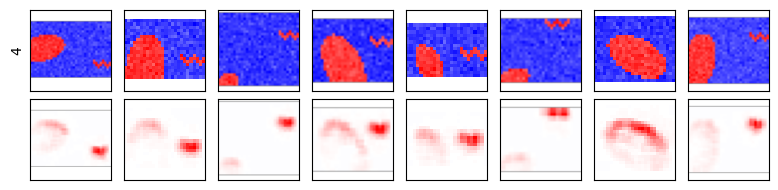

In [6]:
from expbasics.plotting import draw_graph_with_images
model = load_model(MODEL_NAME, 0.98, 7)
model_name = to_name(0.98, 7)
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name)

#nodes, edges, images = crpa.complete_relevance_graph(50)
#draw_graph_with_images(nodes, edges, images)

#res = crpa.compute_feature_vis()

crpa.make_all_references("convolutional_layers.6" , [4], relact="relevance") # "convolutional_layers.6" "linear_layers.0"

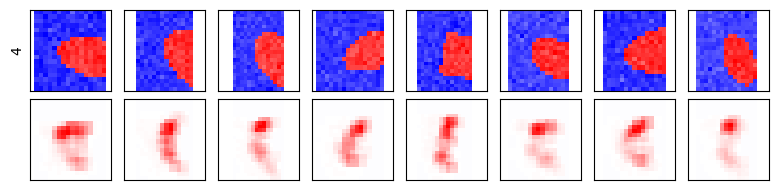

In [37]:
crpa.make_all_references("convolutional_layers.6" , [4], relact="activation") # "convolutional_layers.6" "linear_layers.0"

output: tensor([[ 3.6665, -2.7231]]), 
 latents: [ 0  0  2 12 28], watermark: False, prediction:0 
 convolutional_layers.0: 
 0: 0.22, 1: -0.1, 2: -0.06, 3: 0.28, 4: 0.05, 5: -0.11, 6: 0.07, 7: -0.11 
 convolutional_layers.3: 
 0: -0.09, 1: -0.04, 2: -0.31, 3: -0.07, 4: -0.1, 5: -0.09, 6: -0.02, 7: -0.29 
 convolutional_layers.6: 
 0: -0.37, 1: -0.17, 2: -0.04, 3: 0.08, 4: -0.0, 5: 0.08, 6: -0.15, 7: 0.1 
 linear_layers.0: 
 0: 0.02, 1: 0.21, 2: -0.18, 3: 0.06, 4: 0.18, 5: 0.36 
 linear_layers.2: 
 0: 0.57, 1: -0.43 


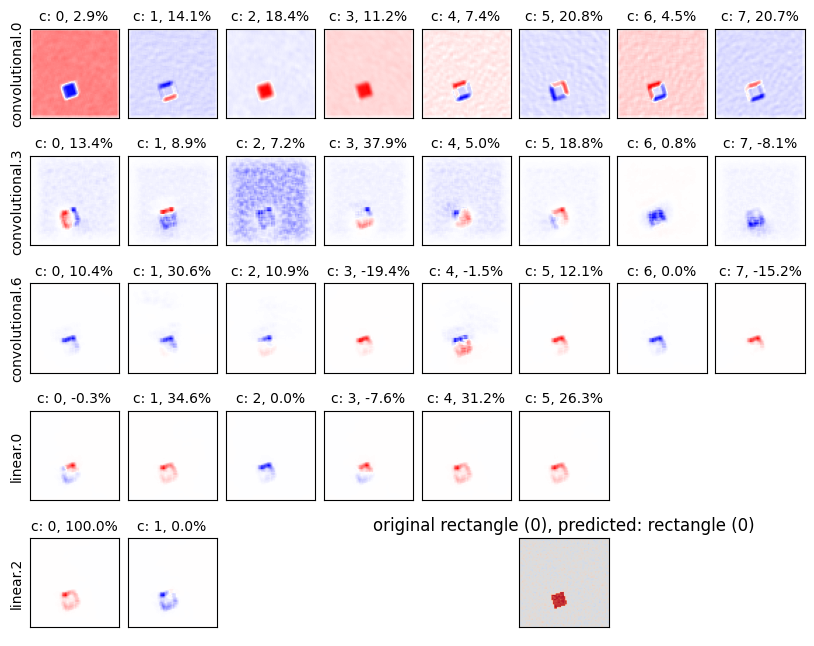

In [7]:
rel = crpa.image_info(5, verbose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

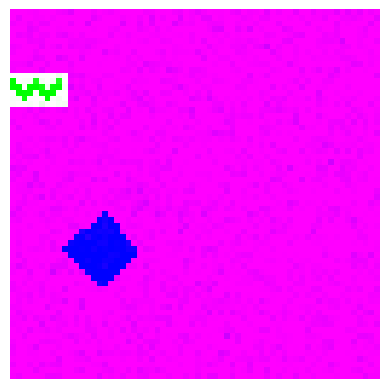

In [8]:
res = crpa.watermark_importance(50)
image = copy.deepcopy(ds[50][0])
img = torch.zeros(64,64,3)
img[:,:,0] = (image[0] * -1) + 1
img[:,:,2] = (image[0] * res["mask"] * -1) + 1
img[np.where(res["mask"] == 1)[0],np.where(res["mask"] == 1)[1],1] = 1
plt.imshow(img)
plt.axis("off")

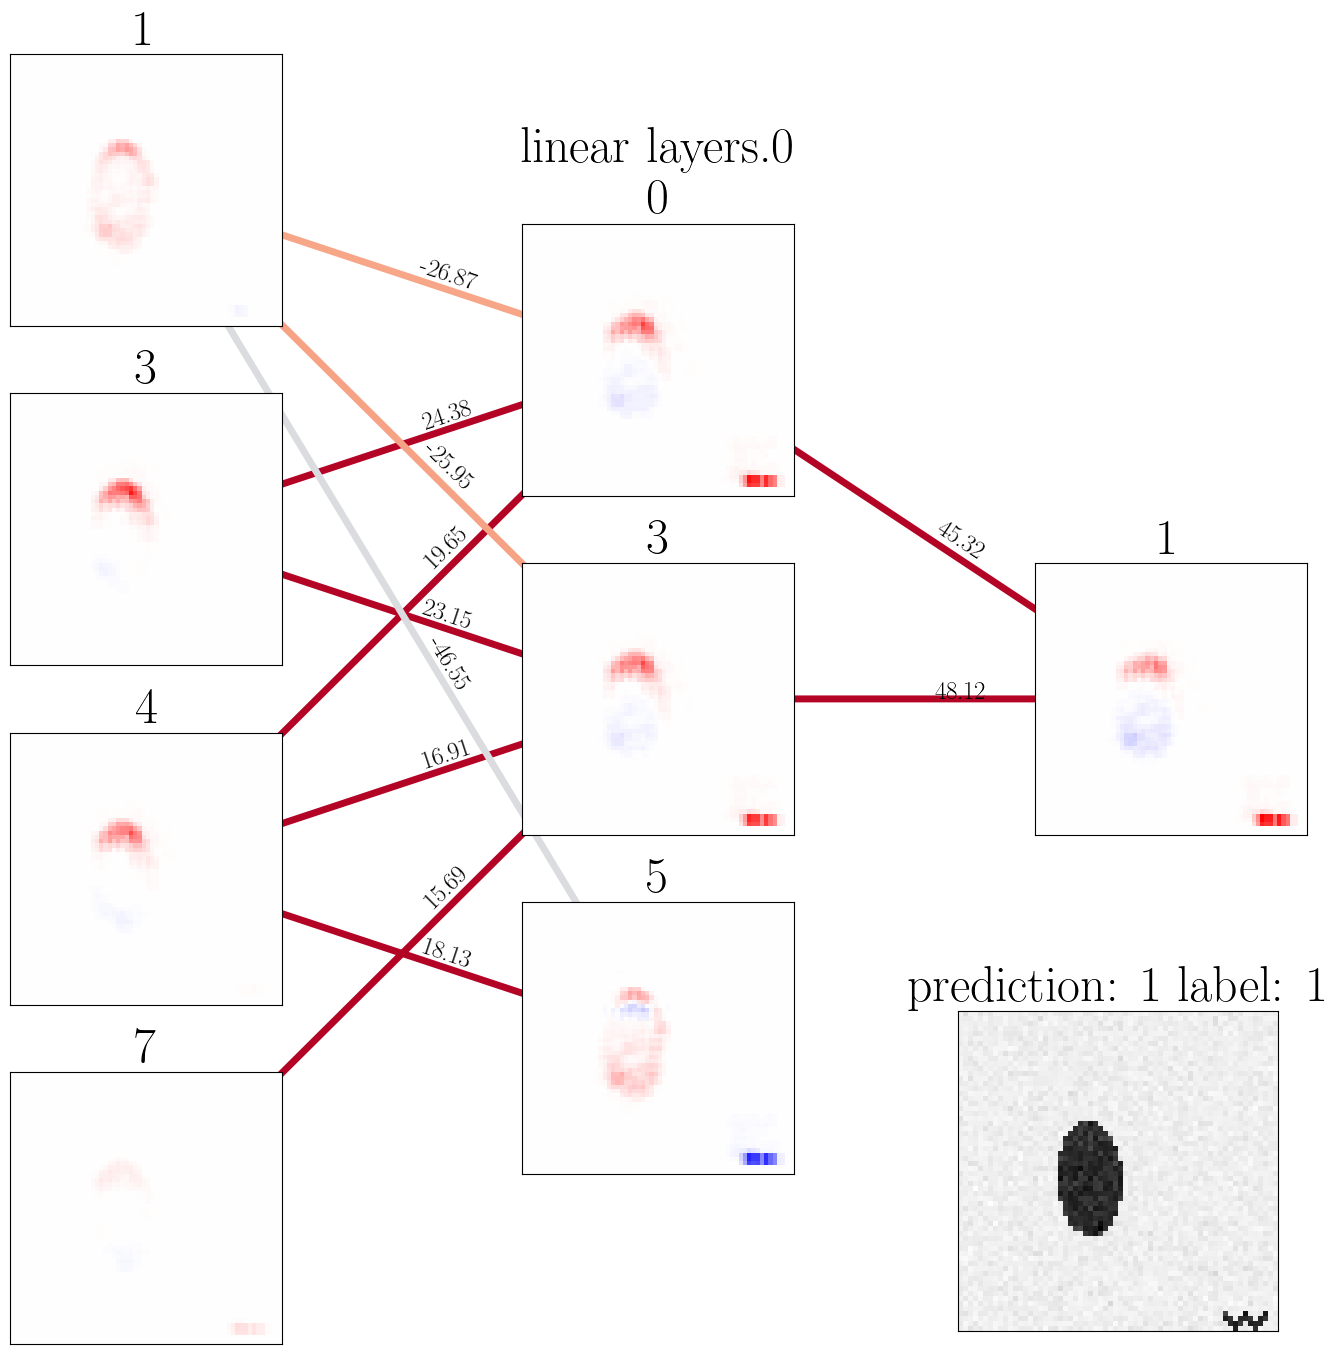

In [290]:
b, m = 0.96, 7

plt.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'font.family': 'serif', "font.size": 30})
# 854
index = 854
model = load_model(MODEL_NAME, b, m )
model_name = to_name(b, m )
crpa = CRPAttribution(model, ds, MODEL_NAME, model_name)

nodes, edges, images = crpa.complete_relevance_graph(index)
draw_graph_with_images(nodes, edges, images)

Counter({-1: 2506, 5: 675, 3: 399, 0: 262, 1: 118, 2: 88, 4: 48})


(-0.5, 63.5, 63.5, -0.5)

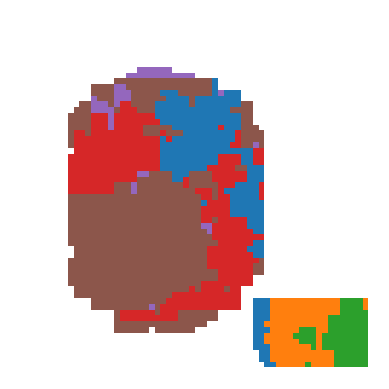

In [291]:
from expbasics.visualizations import my_plot_grid
from collections import Counter

chms = torch.zeros(6, 64, 64)

""" for neuron in range(8):
    chms[neuron] = images[f"convolutional_layers.6_{neuron}"][0] """
for neuron in range(6):
    chms[neuron] = images[f"linear_layers.0_{neuron}"][0]

maxact = torch.max(chms.abs(), dim=0)
concept_atlas = torch.where(maxact.values == 0, 0, maxact.indices + 1)
print(Counter((concept_atlas -1).flatten().tolist()))
cs = [
    (1, 1, 1),
    (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
    (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
]


cm = matplotlib.colors.ListedColormap(cs)
plt.imshow(concept_atlas, cmap=cm, vmin=0, vmax=10)
""" fig = plt.figure(figsize=(6.4,6.4))
for i in range(64):
    for j in range(64):
        plt.scatter(j,i, color=colors[concept_atlas[i,j]],marker="s") """
plt.axis("off")

(-0.5, 9.5, 1.5, -0.5)

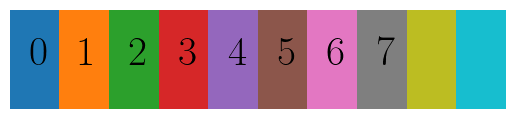

In [289]:
gradient = np.linspace(0, 1, 10)
gradient = np.vstack((gradient, gradient))
res = plt.imshow(gradient, cmap="tab10")
print()
for i in range(8):
    plt.text( i- 0.1,0.6, str(i))
plt.axis("off")

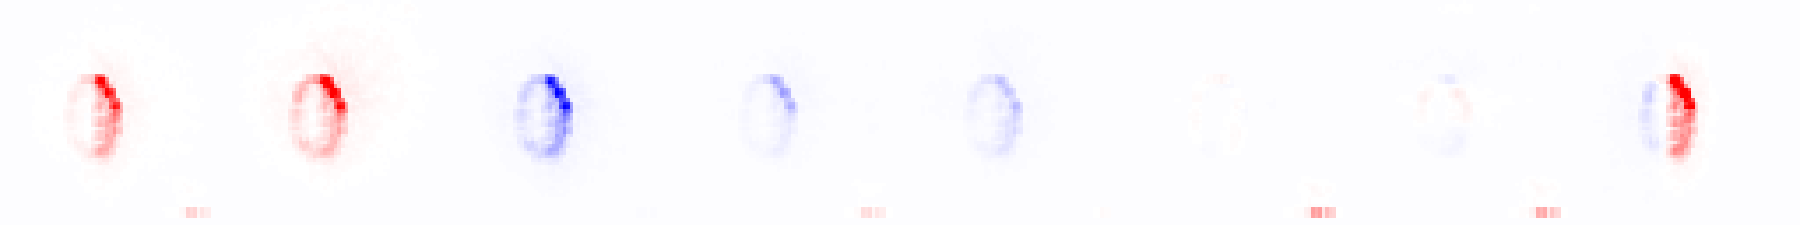

In [281]:
imgify(chms, resize=1800,vmax=.5,vmin=-0.5, grid=(1,8))

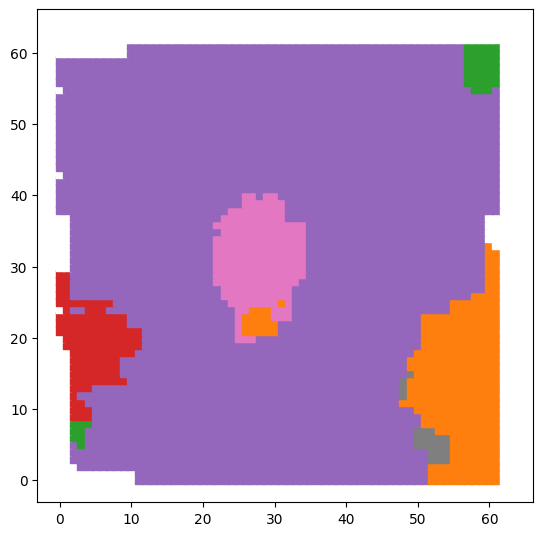

In [223]:
fig = plt.figure(figsize=(6.4,6.4))
for i in range(64):
    for j in range(64):
        plt.scatter(j,i, color=cs[concept_atlas[i,j]],marker="s")

In [248]:
c =  matplotlib.cm.get_cmap('tab10')
print([c(i) for i in range(10)])

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


/tmp/ipykernel_2597324/250047823.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c =  matplotlib.cm.get_cmap('tab10')


(-0.5, 63.5, 63.5, -0.5)

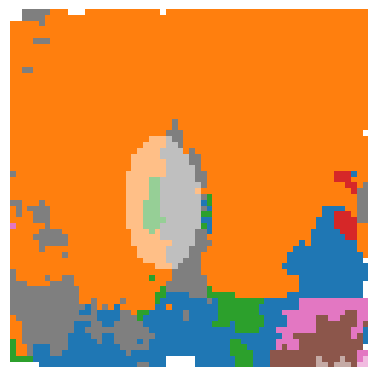

In [273]:
img = cm(concept_atlas)
realimg = images["original"][0] > 0.5 

img[:,:,3] -= 0.5*realimg
plt.imshow(img)
plt.axis("off")

In [ ]:

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111, frame_on=False)

nodes = ["N_w", "N_s", "G", "S", "W", "TS", "i", "M", "P", "E"]
edges = [
    ("N_w", "W"),
    ("N_s", "S"),
    ("G", "W"),
    ("G", "S"),
    ("L", "TS"),
    ("L", "i"),
    ("W", "TS"),
    ("W", "i"),
    ("S", "TS"),
    ("S", "i"),
    ("TS", "M"),
    ("M", "P"),
    ("i", "P"),
    ("G", "P"),
    ("P", "E"),
    ("i", "E"),
    ("M", "E"),
]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx(
    G,
    ax=ax,
    pos=pos,
)

In [ ]:
res =crpa.image_info(400,verbose=True, onlywm=True)

In [ ]:
from expbasics.visualizations import my_plot_grid

indices = range(0, MAX_INDEX, 64300)
print(list(indices))
images = torch.zeros(2, 4, 64, 64)
for i, index in enumerate([0, 128600, 257200, 385800]):
    images[0, i] = ds[index][0]
    images[1, i], pred = crpa.heatmap(index)


my_plot_grid(images, 2, 4, resize=4)

In [ ]:
im_frame = Image.open('suppresor.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = (vals +1) % 2
image, wm = ds[200003]

""" image = np.load("../dsprites-dataset/images/200003.npy", mmap_mode="r")
image = torch.from_numpy(np.asarray(image, dtype=np.float32)).view(1, 64, 64) """
p = 0.7
test = image[0]*(p*vals + (1-p)*np.random.normal(0.0, 0.1, (64, 64)))
plt.imshow(test, cmap="Greys")
plt.axis("off")

with open(f"suppressor.npy", "wb") as f:
    np.save(f, vals.numpy(), allow_pickle=True)

In [2]:
from measures0_to_2 import AllMeasures
%reload_ext autoreload
%autoreload 2

layer_name = "convolutional_layers.6"
allm = AllMeasures("../dsprites-dataset/images/", 10)
allm.recompute_measures(layer_name, ["m2_crv","m1_phi"])

  0%|          | 0/2 [00:00<?, ?it/s, m=0]


AttributeError: 'numpy.ndarray' object has no attribute 'abs'